In [1]:
from scipy.io import loadmat
import h5py
import re
import numpy as np
import validation
from matplotlib import pyplot as plt
import pandas as pd
from scipy import signal

In [2]:
py_filepath = 'C:/Users/camil/Documents/int/data/openephys/test_results/LIP/2022-11-22_10-59-03_Riesling_lip_e1_r1.npy'
mat_filepath = "C:/Users/camil/Documents/int/data/openephys/test_results/LIP/221122_TSCM_5cj_5cl_Riesling.mat"

### Load files

In [3]:
# Matlab
# mat_res = validation.read_matlab_file(mat_filepath)
# print(mat_res.keys())

In [4]:
# Python
py_f = np.load(py_filepath,allow_pickle=True).item(0)
sp_py = py_f['sp_data']
bhv_py = py_f['bhv']
print('sp_py keys:')
print(sp_py.keys())
print('bhv_py trial keys:')
print(bhv_py[0].keys())

sp_py keys:
dict_keys(['sp_samples', 'blocks', 'code_numbers', 'code_samples', 'eyes_values', 'lfp_values', 'samples', 'clusters_id', 'clusters_ch', 'clustersgroup', 'clusterdepth'])
bhv_py trial keys:
dict_keys(['trial', 'AbsoluteTrialStartTime', 'Btn1', 'Btn10', 'Btn2', 'Btn3', 'Btn4', 'Btn5', 'Btn6', 'Btn7', 'Btn8', 'Btn9', 'Eye', 'Eye2', 'EyeExtra', 'Gen1', 'Gen10', 'Gen11', 'Gen12', 'Gen13', 'Gen14', 'Gen15', 'Gen16', 'Gen2', 'Gen3', 'Gen4', 'Gen5', 'Gen6', 'Gen7', 'Gen8', 'Gen9', 'Joystick', 'Joystick2', 'KeyInput', 'Mouse', 'PhotoDiode', 'SampleInterval', 'Touch', 'CodeNumbers', 'CodeTimes', 'Block', 'BlockCount', 'Condition', 'CycleRate', 'Angle', 'BackgroundColor', 'Info', 'Position1', 'Position2', 'Position3', 'Position4', 'Position5', 'Position6', 'Scale', 'Status', 'Time', 'Zorder', 'ReactionTime', 'EndTimes', 'StartTimes', 'Attribute11', 'Attribute12', 'Attribute13', 'Attribute21', 'Attribute22', 'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26', 'Code', 'FrameByF

### Select relevant trials

In [5]:
# Selec trials in a block
block = 2
block_idx = np.where(sp_py['blocks']==2)[0]
print('Number of trials in block 2: %d'%len(block_idx))
# Selec correct trials
correct_mask = []
for n_trial in block_idx:
    correct_mask.append(bhv_py[n_trial]['TrialError'][0][0]==0.)
print('Number of correct trials in block 2: %d'%sum(correct_mask))
block_idx = block_idx[correct_mask]
b_sp_samples = [sp_py['sp_samples'][i] for i in block_idx]
print('Number of clusters: %d'%len(b_sp_samples[0]))


Number of trials in block 2: 104
Number of correct trials in block 2: 80
Number of clusters: 16


### Select trials by target code

In [6]:
target_codes= {
    '127': [[10,0],[1,2]],
    '126': [[7,7],[0,2]],
    '125': [[0,10],[0,1]],
    '124': [[-7,7],[0,0]],
    '123': [[-10,0],[1,0]],
    '122': [[-7,-7],[2,0]],
    '121': [[0,-10],[2,1]],
    '120': [[7,-7],[2,2]],
}

In [7]:
# create dict with the trials that have each code
trials_idx = {}

for i_key,key in enumerate(target_codes.keys()):
    trials = []
    code_idx=[]
    for i_trial,code in zip(block_idx, sp_py['code_numbers'][block_idx]):
        idx=np.where(int(key) == code)[0]
        if len(idx)!=0:
            code_idx.append(idx[0])
            trials.append(i_trial)
    trials_idx[key]={'code_idx':code_idx,'trials_idx':trials}

### create list of neurons containing trials belonging to one target location

In [8]:
def get_neuron_in_trials(code,trials_idx,sp_py,neuron,target_on):
    target_trials= trials_idx[code]['trials_idx'] # select trials idx
    code_trials = sp_py['sp_samples'][target_trials] # select trials
    neuron_trials = []
    for i_t,n_trial in zip(target_trials,code_trials):
        idx_target_on = np.where(sp_py['code_numbers'][i_t]==target_on)[0]
        sample_target_on = sp_py['code_samples'][i_t][idx_target_on]
        neuron_trials.append(n_trial[neuron]-sample_target_on)
    return np.array(neuron_trials,dtype='object') 

#### Plot all trials with the same code for one neuron 

In [14]:
code = '124'
n_neuron = 1
# select only individual neurons
neuron = np.where(sp_py['clustersgroup']=='good')[0][n_neuron]
# 37 Target ON
target_on = 37
neuron_trials = get_neuron_in_trials(code,trials_idx,sp_py,neuron,target_on)

##### Compute the Average firing rate

In [15]:
def trial_average_fr(neuron_trials):
    sorted_sp_neuron = np.sort(np.concatenate(neuron_trials))
    sum_sp = np.zeros(sorted_sp_neuron[-1]-sorted_sp_neuron[0]+1)
    sorted_sp_shift = sorted_sp_neuron-sorted_sp_neuron[0]

    for i in sorted_sp_shift:
        sum_sp[i]+=1 
    trial_average_sp=sum_sp/len(neuron_trials) 
    return trial_average_sp,sorted_sp_neuron

In [16]:
# define kernel for the convolution
fs = 30000
w = 0.015 # seconds = 15 ms
w_size = 0.1 # seconds = 100ms
kernel = signal.gaussian(M=w_size*fs,std=w*fs)/w_size

trial_average_sp,sorted_sp_neuron = trial_average_fr(neuron_trials)

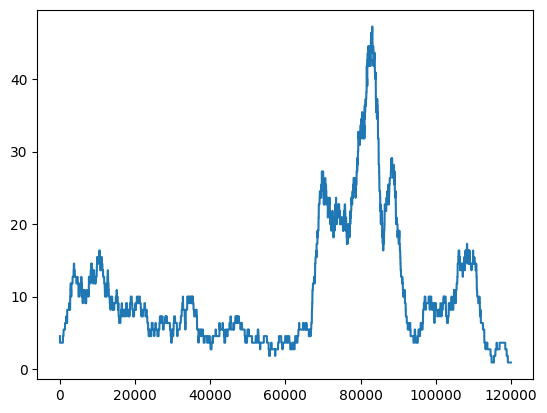

In [17]:
fr = []
for i in range(len(trial_average_sp)):
    fr.append(sum(trial_average_sp[i:i+int(w_size*fs)])/w_size)
plt.plot(fr)

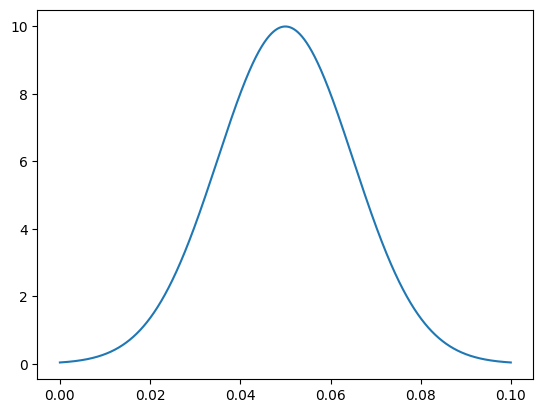

In [18]:
plt.plot(np.arange(len(kernel))/fs,kernel)

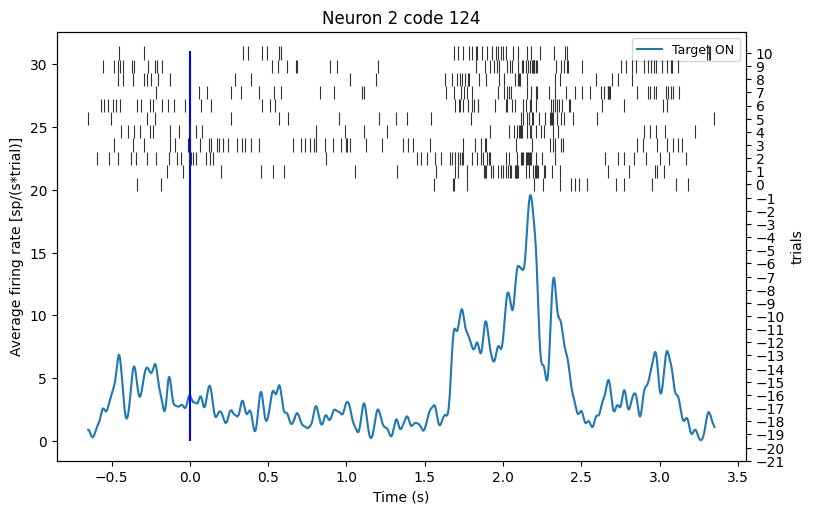

In [19]:
# Plot
num_trials= len(neuron_trials)
fig,ax = plt.subplots(figsize=(8, 5))
ax2 = ax.twinx()
# fr
conv = np.convolve(trial_average_sp,kernel,mode='same')
ax.plot((np.arange(len(trial_average_sp)) + sorted_sp_neuron[0])/fs,conv)
# raster
max_conv = int(max(conv)+2)
lineoffsets=np.arange(max_conv,num_trials+max_conv)
a=ax2.eventplot(neuron_trials/fs, color=".2",lineoffsets=1,linewidths=0.8)
# events
ax.vlines(0,0,lineoffsets[-1],color='b')

ax.set(xlabel="Time (s)", ylabel='Average firing rate [sp/(s*trial)]')
ax2.set(xlabel="Time (s)", ylabel='trials')

ax.set_title('Neuron %d code %s'%(neuron,code))
ax2.set_yticks(range(-max_conv,num_trials))
ax.legend(['Target ON'], fontsize=9)
fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)

#### Plot all trials with the same code for all neurons 

In [20]:
def plot_raster_fr(trial_average_sp,sorted_sp_neuron,conv,fs,neuron_trials,code):    
    num_trials= len(neuron_trials)
    ax2 = ax.twinx()
    # fr
    ax.plot((np.arange(len(trial_average_sp)) + sorted_sp_neuron[0])/fs,conv)
    # raster
    max_conv = int(max(conv)+2)
    lineoffsets=np.arange(max_conv,num_trials+max_conv)
    a=ax2.eventplot(neuron_trials/fs, color=".2",lineoffsets=1,linewidths=0.8)
    # events
    ax.vlines(0,0,lineoffsets[-1],color='b',linestyles='dashed')
    # figure setings
    ax.set(xlabel="Time (s)", ylabel='Average firing rate')
    ax2.set(xlabel="Time (s)", ylabel='trials')
    ax2.set_yticks(range(-max_conv,num_trials))
    ax.set_title('Code %s'%(code), fontsize=8)
    ax.set_xlim(-0.7,2)
    plt.setp(ax2.get_yticklabels(),visible=False)
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    fig.suptitle('Neuron %d'%(i+1), x=0)
    return fig

C:\Users\camil\AppData\Local\Temp\ipykernel_1956\2178118996.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((3, 3), (axis[0], axis[1]))


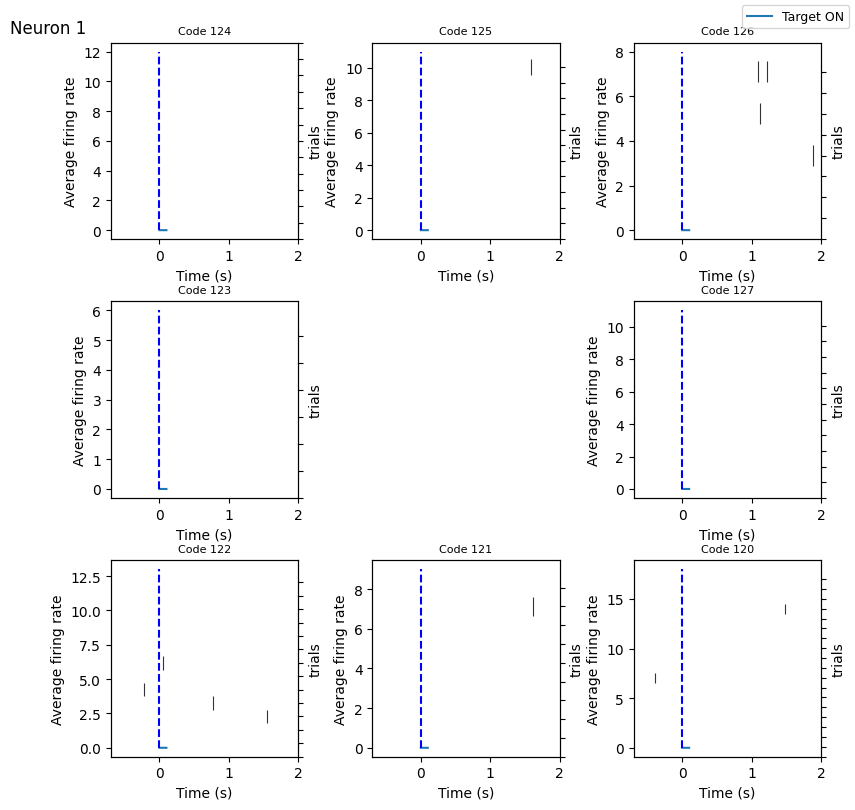

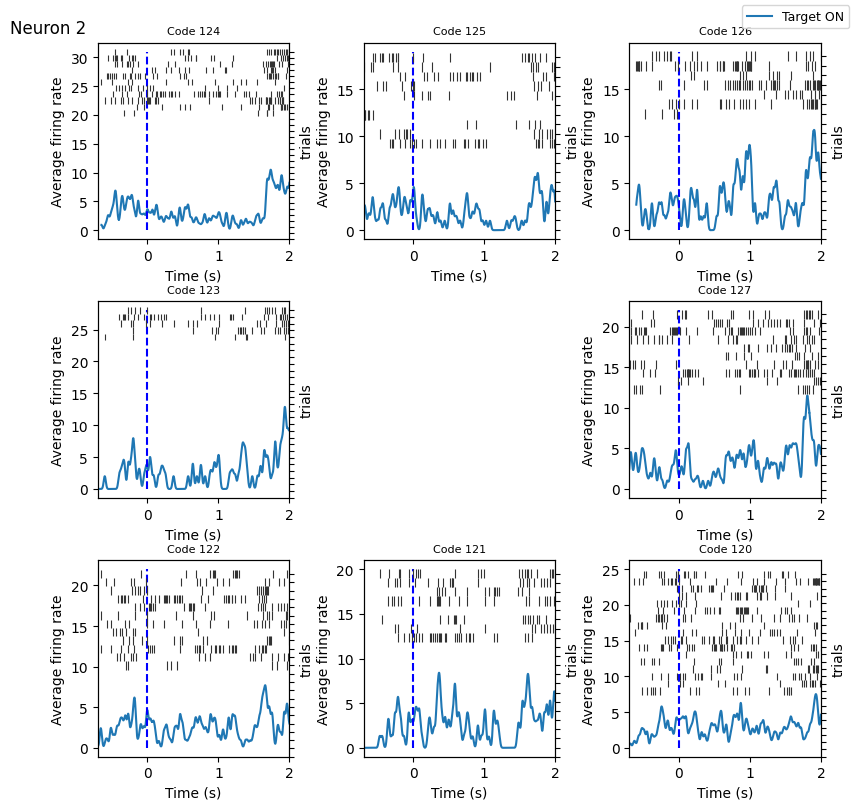

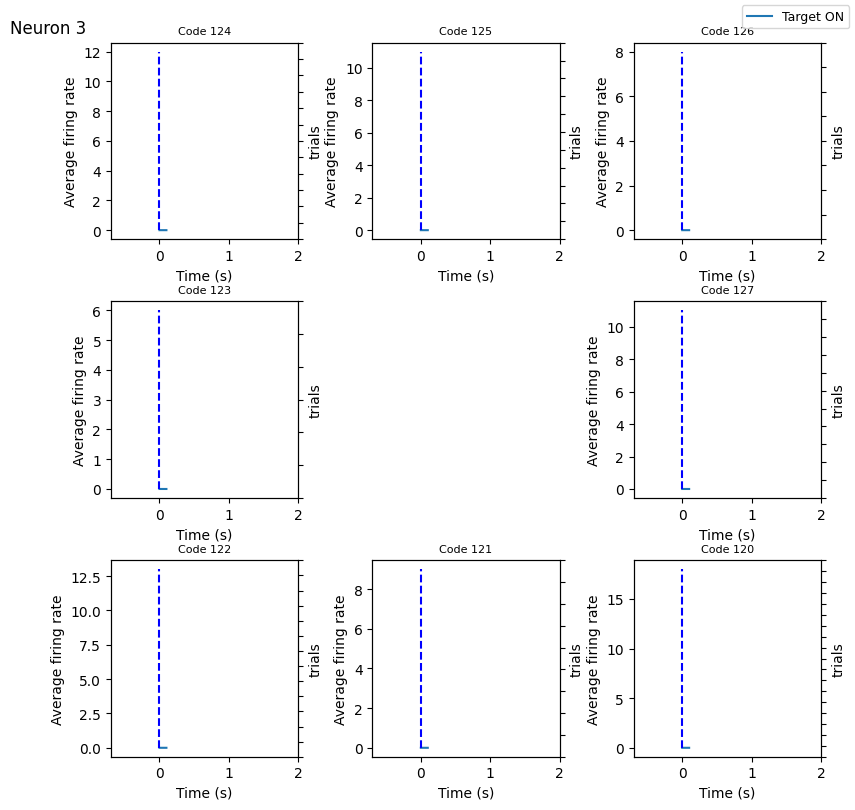

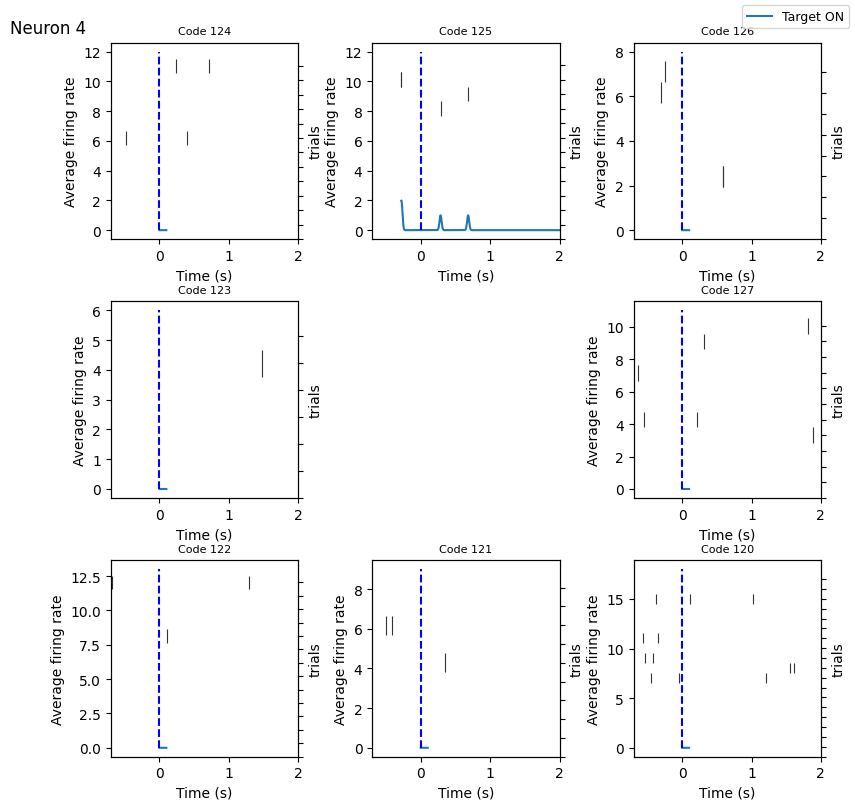

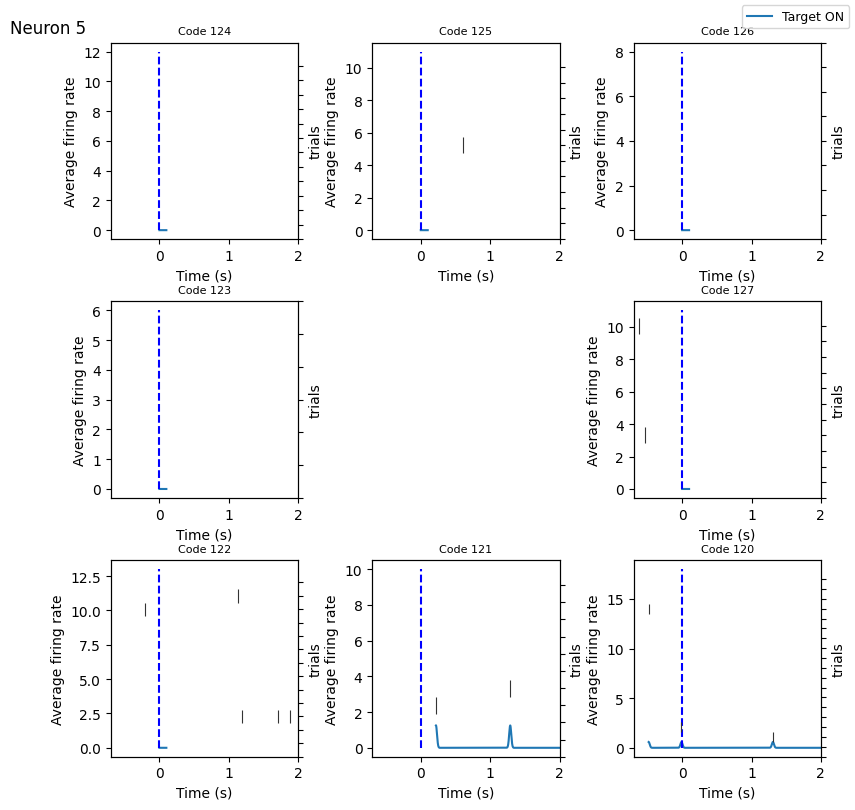

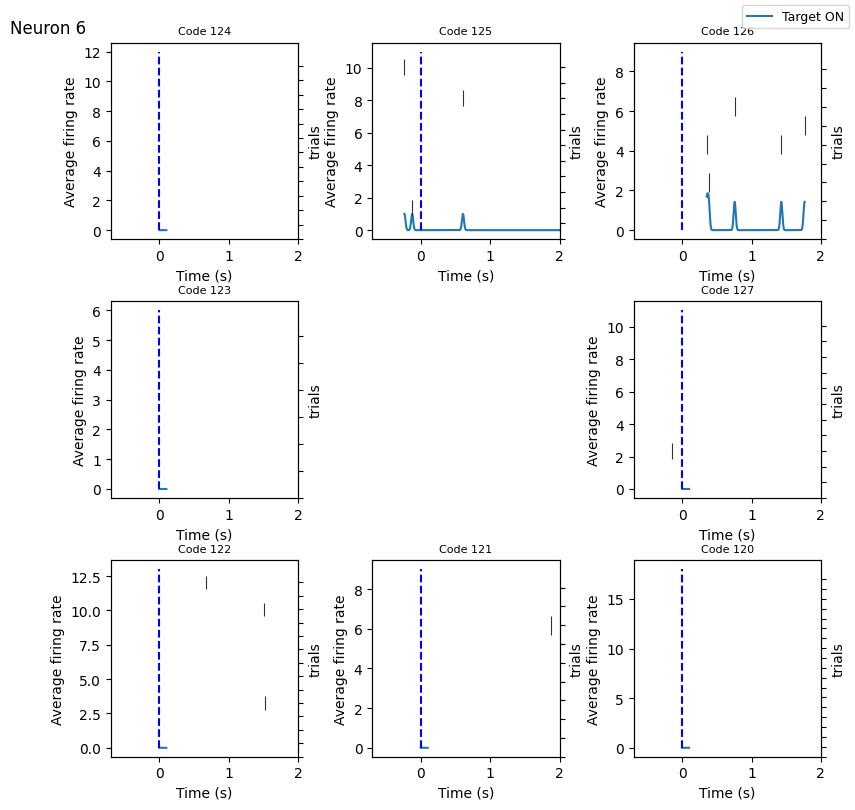

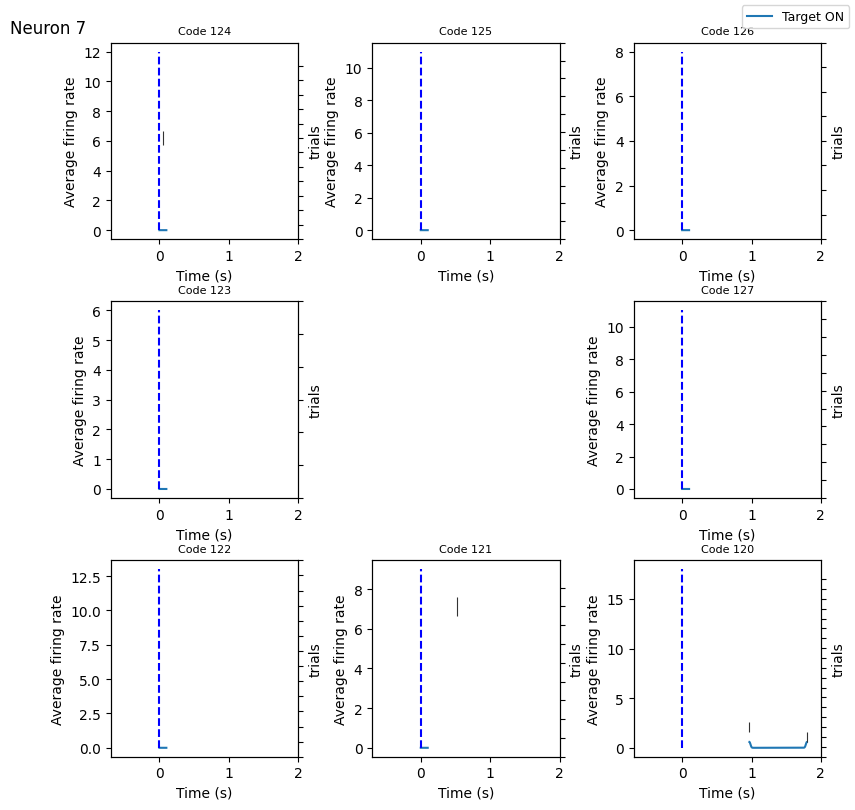

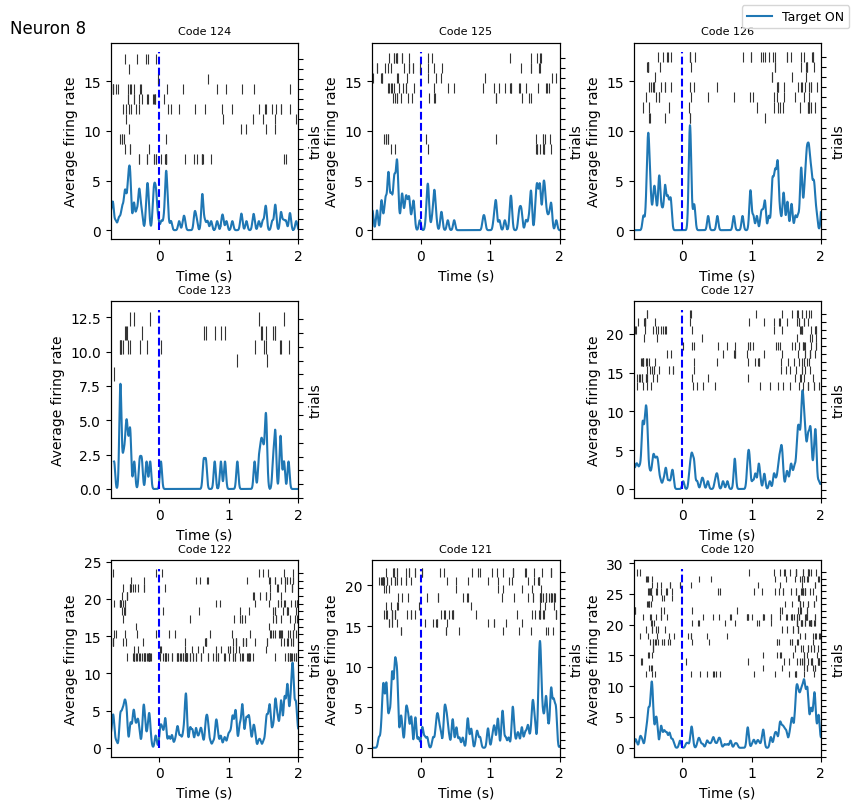

In [21]:
fs = 30000
#neuron = 7
neurons = np.where(sp_py['clustersgroup']=='good')[0]
for i,neuron in enumerate(neurons):
    fig,ax = plt.subplots(figsize=(8, 8),sharex=True,sharey=True)
    for code in target_codes.keys():
        neuron_trials = get_neuron_in_trials(code,trials_idx,sp_py,neuron,target_on=target_on)
        
        axis= target_codes[code][1]
        ax = plt.subplot2grid((3, 3), (axis[0], axis[1]))
        if len(neuron_trials[0]) != 0:
            # Compute trial average fr
            trial_average_sp,sorted_sp_neuron = trial_average_fr(neuron_trials)
        else:
            trial_average_sp=[0]*len(kernel)
            sorted_sp_neuron=[0]*len(kernel)
        conv = np.convolve(trial_average_sp,kernel,mode='same')
        fig=plot_raster_fr(trial_average_sp,sorted_sp_neuron,conv,fs,neuron_trials,code)
    fig.legend(['Target ON'], fontsize=9)
    plt.show()

#### Check neurons and mua times

In [ ]:
start_idx = np.where(mat_res['/data/NEURO/CodeNumbers'].reshape(1,-1)[0]==9)[0]
end_idx = np.where(mat_res['/data/NEURO/CodeNumbers'].reshape(1,-1)[0]==18)[0]
start_timestamps = mat_res['/data/NEURO/CodeTimes'][0][start_idx]
end_timestamps = mat_res['/data/NEURO/CodeTimes'][0][start_idx[1:]]
end_timestamps = np.append(end_timestamps,[mat_res['/data/NEURO/LFP/timestamps'][0][-1]])

In [ ]:
validation.check_spikes(mat_res, py_f, start_timestamps, end_timestamps)